Changes to be made:
1. Digitize the signal with a uniform Probability distribution between -1 and 1 (0 and 1 seems better but -1 and 1 is used here)
2. Apply Jakes filter (haven't changed the implementation of this, don't see a reason to as of now)
3. AWGN noise
4. LS separation using y = hx + n --- y/h = x + n/h, given n is very small (high SNR) approximate h for the packet, given x of the header and y. This has changed since the last implementation where I used y = Ax + n, given A = I, approximate a good x - not right
5. Divide packet values by the h found and find MSE, bit error rate and correlation of original and predicted signal

Note: the denoising with LS is still highly inaccurate - I'm getting MSEs of 0.001 with AWGN - which means noise isn't being removed - and of the order of e-31 without it
This means the prediction of h is still fine since the SNR is decent, but the noise isn't removed fully. 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import signal as sp
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Generate a digital signal
def generate_digital_signal(length):
    return np.random.choice([-1, 1], size=length)

In [25]:
# Generate Rayleigh channel envelope
def Jakes_filter(f_max, Ts, N):
    L = N // 2
    n = np.arange(1, L + 1)
    J_pos = special.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)  # Use special.jv instead of sp.jv
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))
    return hw

def generate_rayleigh_envelope(signal_length, num_packets):
    fd = 10
    Fs = 100
    N = 512
    Ts = 1 / Fs
    h = Jakes_filter(fd, Ts, N)
    x = np.random.randn(signal_length + 1000)
    y = np.convolve(x, h, 'valid')
    return y[:num_packets]


In [7]:
def apply_rayleigh_fading(packets, rayleigh_values):
    return [packet * rayleigh_value for packet, rayleigh_value in zip(packets, rayleigh_values)]

In [9]:
def add_awgn_noise(signal, snr_db):
    snr = 10 ** (snr_db / 10)
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / snr
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise

In [11]:
# Estimate h using least squares - we neglect n/h since it is very low
def estimate_h(x_known, y):
    return lstsq(x_known.reshape(-1, 1), y)[0][0]


In [15]:
# Divide packet values by estimated h
def apply_channel_estimation(packets, h_estimates):
    return [packet / h for packet, h in zip(packets, h_estimates)]

In [95]:
def plot_results(original_x, y, estimated_x):
    # Plot original and predicted x
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Original signal
    ax1.plot(original_x[:5120], label='Original x')
    ax1.set_title('Original Signal')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    # Estimated signal
    ax2.plot(estimated_x[:5120], label='Estimated x', color='orange')
    ax2.set_title('Estimated Signal')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Amplitude')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    # Plot noisy x (y)
    plt.figure(figsize=(12, 6))
    plt.plot(y[:5120], label='y (scaled and noisy)', color = "g")
    plt.legend()
    plt.title('Noisy Signal (y)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()


In [97]:
# Function to run the entire process
def run_signal_processing():
    # Parameters
    signal_length = 51200
    packet_size = 256
    num_packets = 200
    snr_db = 10 * np.log10(1000)

    original_signal = generate_digital_signal(signal_length)
    rayleigh_envelope = generate_rayleigh_envelope(signal_length, num_packets)
    
    # Splits the sequence into multiple subarrays, all contained in a list to be traversed
    packets = np.array_split(original_signal, num_packets)
    
    faded_packets = apply_rayleigh_fading(packets, rayleigh_envelope)
    noisy_packets = [add_awgn_noise(packet, snr_db) for packet in faded_packets]
    #noisy_packets = faded_packets
    
    # LS estimation
    h_estimates = [estimate_h(packet[:16], noisy_packet[:16]) for packet, noisy_packet in zip(packets, noisy_packets)]
    estimated_packets = apply_channel_estimation(noisy_packets, h_estimates)

    # Join the packets to create the original signal
    original_x = np.concatenate(packets)
    y = np.concatenate(noisy_packets)
    estimated_x = np.concatenate(estimated_packets)

    # Plotting
    plot_results(original_x, y, estimated_x)
    
    # Calculate MSE
    mse = mean_squared_error(original_x, estimated_x)
    print(f"Mean Squared Error (MSE): {mse}")

    # Calculate correlation
    correlation = np.corrcoef(original_x, estimated_x)[0, 1]
    print(f"Correlation: {correlation}")
    
    return original_x, y, estimated_x

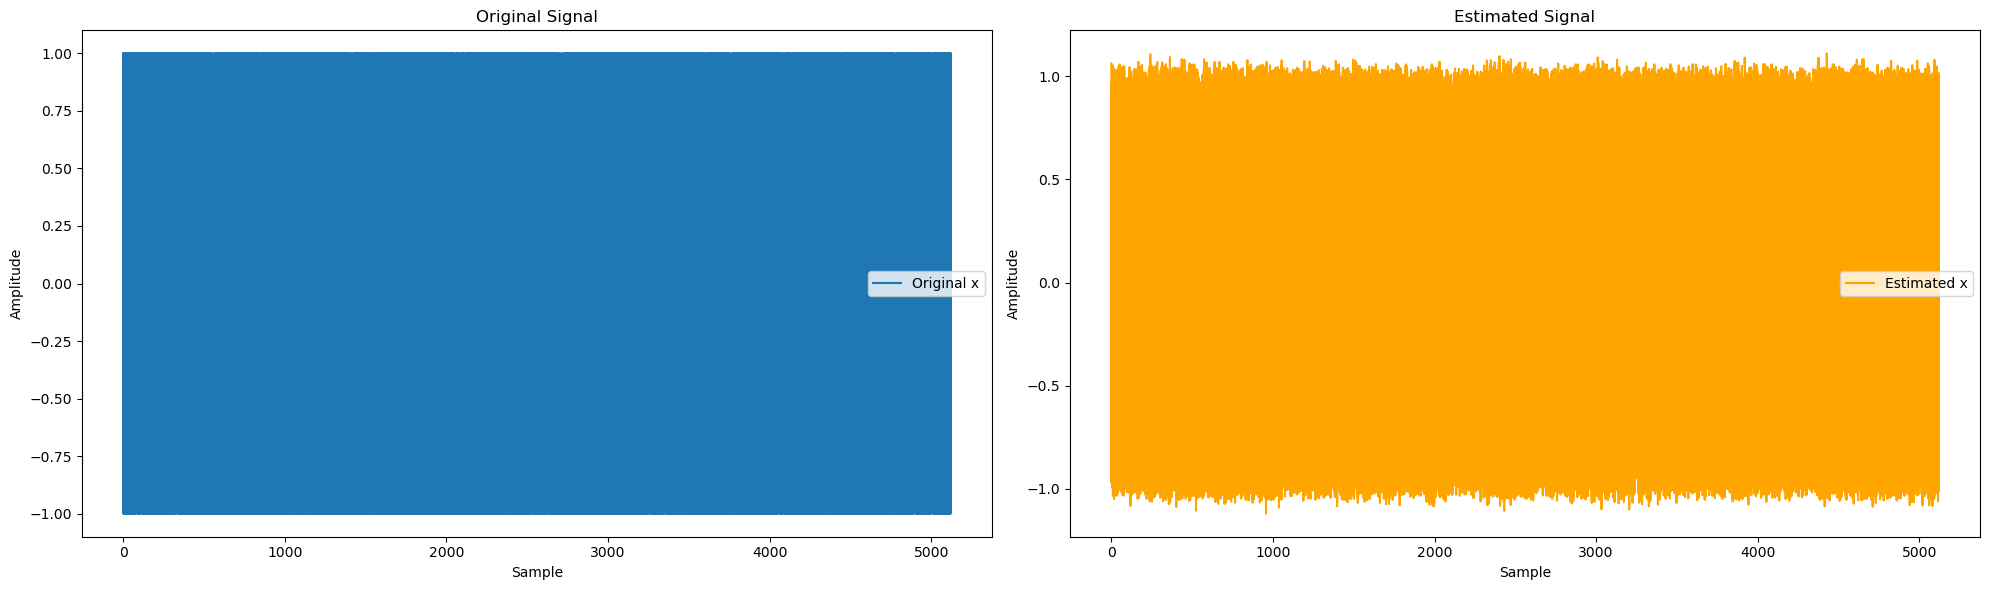

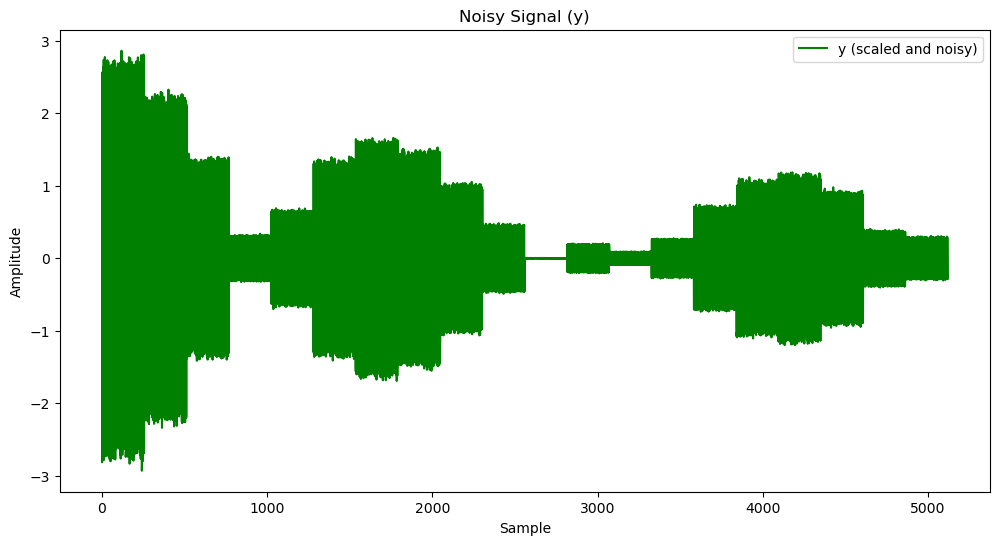

Mean Squared Error (MSE): 0.0010598462134747174
Correlation: 0.9994706633733762


In [99]:
# Run the entire process
original_x, y, estimated_x = run_signal_processing()

In [92]:
total = 51200
right = 0
for i in range(51200):
    #Set a threshold of 5% around the original value for the bit to be right
    if abs(abs(estimated_x[i] - original_x[i])/original_x[i])<0.05:
        right += 1
print(f"Accuracy = {right/total}")
    
    

Accuracy = 0.87626953125
